In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import sys
sys.path.append("../../") # Add parent directory to sys.path to access preprocessing module
sys.path.append("../") # Add parent directory to sys.path to access preprocessing module

from preprocessing.data_augmentor import DataAugmentor
from preprocessing.feature_extractor import FeatureExtractor
from preprocessing.sampler import Sampler

In [2]:
# Print working directory
import os
print(os.getcwd())

data_dir = "../../data/Composer_Dataset"
composers = ["Bach", "Beethoven", "Chopin", "Mozart"]
scalar_features, multidimensional_features = FeatureExtractor.extract_features_for_directory(data_dir, composers)

/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/src/cnn
Loading existing features from ../../data/Composer_Dataset/extracted_features.pkl


In [3]:
scalar_features.head()

,max_independent_voices,avg_independent_voices,var_independent_voices,avg_simultaneity,var_simultaneity,note_density,avg_note_duration,var_note_duration,initial_tempo,time_signature_numerator,...,perfect_vertical_intervals,vertical_minor_seconds,vertical_thirds,vertical_fifths,vertical_tritones,vertical_octaves,avg_chord_duration,length,file_name,composer
0,4.0,3.899642,0.300477,3.720000,1.020588,6.439026,0.621212,0.296121,143.000038,4.0,...,0.391195,0.000000,0.327044,0.200000,0.045283,0.122013,0.465000,29.999992,042100b_.mid,Bach
1,4.0,3.986667,0.114698,3.600000,1.200000,7.394595,0.526316,0.250579,189.176471,4.0,...,0.400447,0.005220,0.307979,0.168531,0.042506,0.123788,0.321429,25.000000,043100b_.mid,Bach
2,7.0,2.664012,1.617631,2.331998,1.816512,6.292553,0.371665,0.686803,181.905446,4.0,...,0.378734,0.006634,0.291590,0.120602,0.057594,0.158185,0.177695,923.701235,Bwv0564-Toccata-Adagio-and-Fugue.mid,Bach
3,4.0,3.970874,0.168160,3.662222,1.112213,8.775758,0.455801,0.212811,177.509434,4.0,...,0.375205,0.009852,0.312808,0.130542,0.030378,0.115764,0.321875,22.500000,027400b_.mid,Bach
4,4.0,3.917323,0.275394,3.455782,1.371385,5.195127,0.713614,0.442007,153.000153,4.0,...,0.478439,0.002738,0.309377,0.206023,0.016427,0.140999,0.470370,29.333304,026400b_.mid,Bach


In [4]:
print(f"Piano Roll Shape: {multidimensional_features[0]['piano_roll'].shape}")
print(f"Chroma Piano Roll Shape: {multidimensional_features[0]['chroma_piano_roll'].shape}")
print(f"Pitch Class Histogram Shape: {multidimensional_features[0]['pitch_class_histogram'].shape}")
print(f"Pitch Class Transition Matrix Shape: {multidimensional_features[0]['pitch_class_transition_matrix'].shape}")

Piano Roll Shape: (128, 299)
Chroma Piano Roll Shape: (12, 299)
Pitch Class Histogram Shape: (12,)
Pitch Class Transition Matrix Shape: (12, 12)


## CNN Example

### Train Val Test Split

In [5]:
# train_split = 0.8  # ratio of all data to use for training
# val_test_split = 0.5  # ratio of holdout data to use for test set

# x = multidimensional_features
# y = scalar_features['composer']

# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)

# x_train, x_holdout, y_train, y_holdout = train_test_split(x, y, test_size=(1 - train_split), random_state=1)
# x_val, x_test, y_val, y_test = train_test_split(x_holdout, y_holdout, test_size=val_test_split, random_state=1)

In [6]:
y = scalar_features['composer']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

scalar_train, scalar_holdout, multidim_train, multidim_holdout, y_train, y_holdout = Sampler.split_data(scalar_features, multidimensional_features, y, test_size=0.2, random_state=1)

scalar_val, scalar_test, multidim_val, multidim_test, y_val, y_test = Sampler.split_data(scalar_holdout, multidim_holdout, y_holdout, test_size=0.5, random_state=1)

train_composer_files = scalar_train[['composer', 'file_name']]
scalar_features = scalar_features.drop('file_name', axis=1)
scalar_train.drop(['composer', 'file_name'], axis=1, inplace=True)
scalar_val.drop(['composer', 'file_name'], axis=1, inplace=True)
scalar_test.drop(['composer', 'file_name'], axis=1, inplace=True)

/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_54761/2216297816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scalar_val.drop(['composer', 'file_name'], axis=1, inplace=True)
/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_54761/2216297816.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scalar_test.drop(['composer', 'file_name'], axis=1, inplace=True)


{'Bach': 815, 'Mozart': 215, 'Beethoven': 176, 'Chopin': 102}


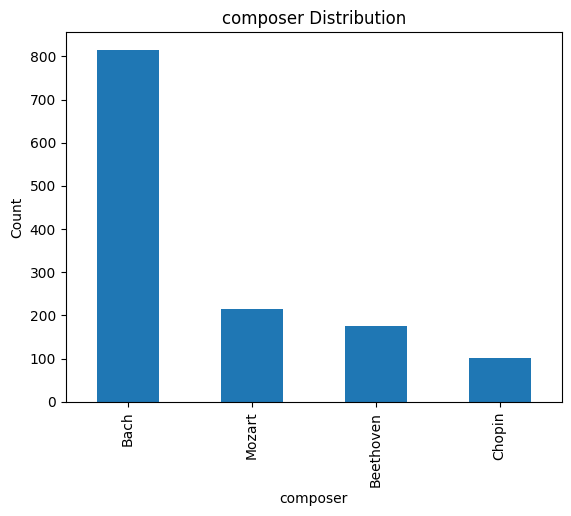

In [7]:
def plot_column_distribution(data: pd.DataFrame, column: str) -> None:
    print(dict(data[column].value_counts()))
    data[column].value_counts().plot(kind='bar')
    plt.title(f'{column} Distribution')
    plt.xlabel(f'{column}')
    plt.ylabel(f'Count')
    plt.show()
    
train_composers = pd.DataFrame(label_encoder.inverse_transform(y_train), columns=['composer'])
plot_column_distribution(train_composers, 'composer')

{'Mozart': 815, 'Bach': 815, 'Beethoven': 815, 'Chopin': 815}


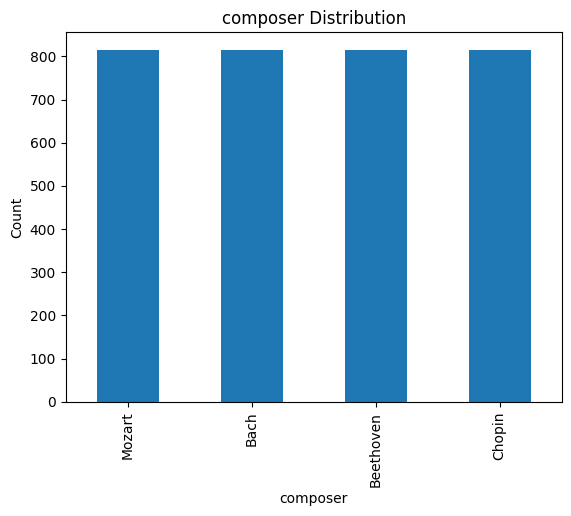

In [8]:
scalar_train, multidim_train, y_train = Sampler.oversample_balance(scalar_train, multidim_train, y_train)
train_composers = pd.DataFrame(label_encoder.inverse_transform(y_train), columns=['composer'])
plot_column_distribution(train_composers, 'composer')

In [9]:
num_augmented_songs = 100
mozart_aug_scalars, mozart_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Mozart'], num_augmented_songs)
bach_aug_scalars, bach_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Bach'], num_augmented_songs)
beethoven_aug_scalars, beethoven_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Beethoven'], num_augmented_songs)
chopin_aug_scalars, chopin_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Chopin'], num_augmented_songs)

scalar_train = pd.concat([scalar_train, mozart_aug_scalars, bach_aug_scalars, beethoven_aug_scalars, chopin_aug_scalars], axis=0)
multidim_train = multidim_train + mozart_aug_multidim + bach_aug_multidim + beethoven_aug_multidim + chopin_aug_multidim

mozart_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Mozart']))
bach_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Bach']))
beethoven_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Beethoven']))
chopin_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Chopin']))
y_train = np.hstack((y_train, mozart_aug_y, bach_aug_y, beethoven_aug_y, chopin_aug_y))

Generating Augmented Songs:   1%|          | 1/100 [00:04<07:01,  4.26s/song]/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Generating Augmented Songs:   2%|▏         | 2/100 [00:04<03:28,  2.13s/song]/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
Generating Augmented Songs: 100%|██████████| 100/100 [02:25<00:00,  1.45s/song]


NameError: name 'np' is not defined

In [10]:
import numpy as np
mozart_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Mozart']))
bach_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Bach']))
beethoven_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Beethoven']))
chopin_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Chopin']))
y_train = np.hstack((y_train, mozart_aug_y, bach_aug_y, beethoven_aug_y, chopin_aug_y))

{'Mozart': 915, 'Bach': 915, 'Beethoven': 915, 'Chopin': 915}


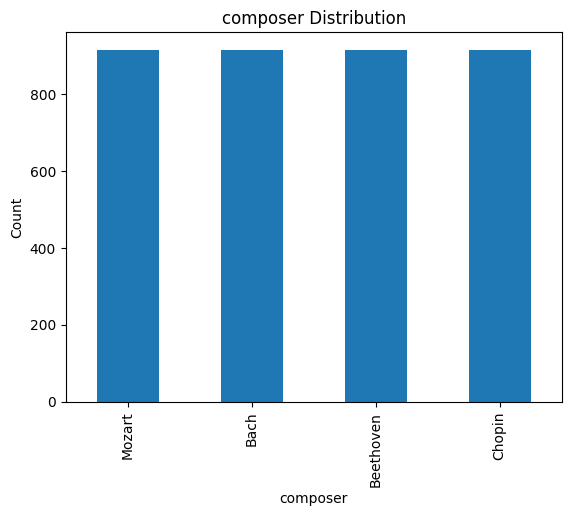

In [11]:
train_composers = pd.DataFrame(label_encoder.inverse_transform(y_train), columns=['composer'])
plot_column_distribution(train_composers, 'composer')

### Chunk Into Sequences

In [12]:
def chunk_sequences(X_in, y_in, feature, sequence_length=100):
    X_out = []
    y_out = []

    # make sequences split along the time axis
    for i in range(len(X_in)):
        for j in range(0, len(X_in[i][feature][1]) - sequence_length, sequence_length):
            X_out.append(X_in[i][feature][:, j:j + sequence_length])
            y_out.append(y_in[i])

    return X_out, y_out

### Make Dataloader

In [13]:
class PianoRollDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32) 
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return X, y

In [14]:
def get_dataloaders(use_chroma, seq_length=100, batch_size=8):


    # Set random seed for PyTorch
    torch.manual_seed(42) 
    
    feature_set = 'chroma_piano_roll' if use_chroma else 'piano_roll'

    X_train_seq, y_train_seq = chunk_sequences(multidim_train, y_train, feature_set, seq_length)
    X_val_seq, y_val_seq = chunk_sequences(multidim_val, y_val, feature_set, seq_length)
    X_test_seq, y_test_seq = chunk_sequences(multidim_test, y_test, feature_set, seq_length)

    train_dataset = PianoRollDataset(X_train_seq, y_train_seq)
    val_dataset = PianoRollDataset(X_val_seq, y_val_seq)
    test_dataset = PianoRollDataset(X_test_seq, y_test_seq)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

### Define CNN

In [15]:
class PianoRollCNN(nn.Module):
    def __init__(self, h_params):
        super(PianoRollCNN, self).__init__()
        # Conv1d layers: input channels = 12, height = 1, width = 50

        input_channels = 12 if h_params['use_chroma'] else 128

        self.conv1 = nn.Conv1d(input_channels, h_params['conv1_out_channels'], 
                               kernel_size=h_params['kernel_size'], stride=h_params['stride'], 
                               padding=h_params['kernel_size'] // 2)
        self.conv2 = nn.Conv1d(h_params['conv1_out_channels'], h_params['conv2_out_channels'], 
                               kernel_size=h_params['kernel_size'], stride=h_params['stride'],
                               padding=h_params['kernel_size'] // 2)
        self.pool = nn.MaxPool1d(kernel_size=h_params['pool_kernel_size'], stride=h_params['pool_stride'], padding=0)

        def conv_output_size(input_size, kernel_size, stride, padding):
            return (input_size - kernel_size + 2 * padding) // stride + 1
    
        padding = h_params['kernel_size'] // 2  # Assuming same padding

        # First conv layer output size
        conv1_output_width = conv_output_size(int(h_params['seq_length']), h_params['kernel_size'], h_params['stride'], padding)
        # First pooling layer output size
        pooled_width = conv_output_size(conv1_output_width, h_params['pool_kernel_size'], h_params['pool_stride'], 0)
        # Second conv layer output size
        conv2_output_width = conv_output_size(pooled_width, h_params['kernel_size'], h_params['stride'], padding)
        # Second pooling layer output size
        pooled_width = conv_output_size(conv2_output_width, h_params['pool_kernel_size'], h_params['pool_stride'], 0)

        self.fc1 = nn.Linear(h_params['conv2_out_channels'] * pooled_width, h_params['fc1_out'])
        self.dropout = nn.Dropout(h_params['dropout'])
        self.fc2 = nn.Linear(h_params['fc1_out'], 4)  # Output of 4 classes (composers)

    def forward(self, x):
        x = x.squeeze(2) # This can potentially be removed if the input is reshaped correctly in the dataloader
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

### Define Training Loop

In [16]:
def train_cnn(model, train_loader, val_loader, num_epochs, criterion, optimizer):

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        report_interval = 1000
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % report_interval == (report_interval - 1):
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / report_interval:.3f}')
                running_loss = 0.0  # Reset running loss

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Validation loss: {val_loss / len(val_loader):.3f}, Accuracy: {100 * correct / total:.2f}%')


### Evaluate Performance

In [17]:
def evaluate_performance(model, data_loader):
    model.eval()

    all_labels = []
    all_predictions = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Store true and predicted labels
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    # Compute the classification report
    report = classification_report(all_labels, all_predictions, target_names=label_encoder.classes_)
    print(report)

    return report, all_labels, all_predictions

### Define Training Run

In [18]:
def training_run(h_params):

    seq_length = int(h_params['seq_length'])
    batch_size = int(h_params['batch_size'])

    train_loader, val_loader, test_loader = get_dataloaders(h_params['use_chroma'], seq_length, batch_size)

    model = PianoRollCNN(h_params)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=h_params['lr'])
    train_cnn(model, train_loader, val_loader, h_params['num_epochs'], criterion, optimizer)

    # TODO: Add model save 
    ###### Save results #####
    return model, test_loader

### Process All Hyperparameter Sets

In [19]:
# Function to process the file and train models
def process_file(file_path):
    infile = pd.read_csv(file_path)

    outputs = ['accuracy', 'bach_f1', 'beethoven_f1', 'chopin_f1', 'mozart_f1']
    floating_point_columns = ['lr']

    for index, row in infile.iterrows():

        # Check that the row has not been processed
        if not pd.isnull(row['accuracy']):
            continue

        # Create hyperparameter dictionary dynamically
        hyperparams = {col: row[col] for col in infile.columns if col not in outputs}
        # Convert int columns to int
        for col in infile.columns:
            if col not in floating_point_columns and col not in outputs:
                hyperparams[col] = int(hyperparams[col])
            elif col in floating_point_columns:
                hyperparams[col] = float(hyperparams[col])

        # Train model
        model, test_loader = training_run(hyperparams)

        # Evaluate performance
        report, all_labels, all_predictions = evaluate_performance(model, test_loader)

        # Write accuracy to data then save
        infile.at[index, 'accuracy'] = float(report.split('\n')[7].split()[1])
        infile.at[index, 'bach_f1'] = float(report.split('\n')[2].split()[3])
        infile.at[index, 'beethoven_f1'] = float(report.split('\n')[3].split()[3])
        infile.at[index, 'chopin_f1'] = float(report.split('\n')[4].split()[3])
        infile.at[index, 'mozart_f1'] = float(report.split('\n')[5].split()[3])
        infile.to_csv(file_path, index=False)


In [20]:
#process_file('cnn_optimization.csv')

## Single Training Run

In [21]:
test_params = {}
test_params['use_chroma'] = False
test_params['seq_length'] = 100
test_params['batch_size'] = 32
test_params['lr'] = 0.0006
test_params['num_epochs'] = 3

test_params['conv1_out_channels'] = 32
test_params['conv2_out_channels'] = 105
test_params['kernel_size'] = 5
test_params['stride'] = 1

test_params['pool_kernel_size'] = 2
test_params['pool_stride'] = 2

test_params['dropout'] = 0.35
test_params['fc1_out'] = 166

model, test_dataloader = training_run(test_params)

report, _, _ = evaluate_performance(model, test_dataloader)

[Epoch 1, Batch 1000] loss: 1.032
[Epoch 1, Batch 2000] loss: 0.800
[Epoch 1, Batch 3000] loss: 0.684
Validation loss: 0.950, Accuracy: 63.40%
[Epoch 2, Batch 1000] loss: 0.552
[Epoch 2, Batch 2000] loss: 0.511
[Epoch 2, Batch 3000] loss: 0.483
Validation loss: 0.993, Accuracy: 67.35%
[Epoch 3, Batch 1000] loss: 0.385
[Epoch 3, Batch 2000] loss: 0.379
[Epoch 3, Batch 3000] loss: 0.372
Validation loss: 1.148, Accuracy: 67.60%
              precision    recall  f1-score   support

        Bach       0.89      0.82      0.85      1619
   Beethoven       0.63      0.64      0.63       901
      Chopin       0.76      0.55      0.64       518
      Mozart       0.39      0.60      0.47       481

    accuracy                           0.70      3519
   macro avg       0.67      0.65      0.65      3519
weighted avg       0.74      0.70      0.71      3519



## Use CNN Predictions and Scalar Features for Classification

Given a single input track make a prediction for each composer using the CNN classifier.

In [22]:
def get_prediction(X_in, feature, sequence_length=100):
    X_sequences = []

    # make sequences split along the time axis
    for j in range(0, len(X_in[feature][1]) - sequence_length, sequence_length):
        X_sequences.append(X_in[feature][:, j:j + sequence_length])
    
    predictions = []

    for i in range(len(X_sequences)):
        inputs = torch.tensor(X_sequences[i], dtype=torch.float32)
        outputs = model(inputs.unsqueeze(0))
        predictions.append(outputs.tolist())

    # Average the prediction values across the sequences
    predictions = torch.tensor(predictions).mean(dim=0)

    return predictions.tolist()[0]

### Add CNN Outputs to Scalar Features

In [23]:
def add_cnn_predictions(multidimensional_features, scalar_features, feature, sequence_length=100):

    # Use the index list of scalar_features to add cnn predictions to correct rows
    index_list = scalar_features.index.tolist()

    for i, md_row in enumerate(multidimensional_features):
        predictions = get_prediction(md_row, feature, sequence_length)
        for idx, prediction in enumerate(predictions):
            column = "composer_" + str(idx)
            scalar_features.loc[index_list[i], column] = prediction

In [24]:
cnn_scalar_train = scalar_train.copy()

print(cnn_scalar_train.shape)

add_cnn_predictions(multidim_train, cnn_scalar_train, 'piano_roll', 100)

print(cnn_scalar_train.shape)

cnn_scalar_test = scalar_test.copy()

add_cnn_predictions(multidim_test, cnn_scalar_test, 'piano_roll', 100)

print(cnn_scalar_train.head())

(3660, 31)
(3660, 35)
   max_independent_voices  avg_independent_voices  var_independent_voices  \
0                     6.0                2.225166                1.031937   
1                     3.0                2.489837                0.725479   
2                    14.0                5.139327                2.394760   
3                     9.0                4.514092                2.177593   
4                    13.0                3.700505                2.075602   

   avg_simultaneity  var_simultaneity  note_density  avg_note_duration  \
0          2.128419          1.106576      9.177566           0.231632   
1          1.734266          1.310800      3.580423           0.482421   
2          8.389987          5.517377     35.148601           0.238669   
3          5.153484          3.577695     20.200832           0.255885   
4          3.543605          2.168105     12.912807           0.275690   

   var_note_duration  initial_tempo  time_signature_numerator  ...  \


### Run Classifier Using CNN Predictions and Scalar Features

In [25]:
classifier = HistGradientBoostingClassifier(random_state=1)
print(scalar_train.shape)
print(cnn_scalar_train.shape)
print(y_train.shape)
classifier.fit(cnn_scalar_train, y_train)

(3660, 31)
(3660, 35)
(3660,)


HistGradientBoostingClassifier(random_state=1)

In [26]:
cnn_scalar_test = scalar_test.copy()

add_cnn_predictions(multidim_test, cnn_scalar_test, 'piano_roll', 100)

In [27]:
y_pred = classifier.predict(cnn_scalar_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

        Bach       0.92      0.98      0.95       101
   Beethoven       0.83      0.68      0.75        22
      Chopin       1.00      0.73      0.84        22
      Mozart       0.73      0.84      0.78        19

    accuracy                           0.89       164
   macro avg       0.87      0.81      0.83       164
weighted avg       0.89      0.89      0.89       164



### Classifier with No CNN Inputs (Baseline)

In [31]:
classifier2 = HistGradientBoostingClassifier(random_state=1)
classifier2.fit(scalar_train, y_train)

HistGradientBoostingClassifier(random_state=1)

In [32]:
y_pred2 = classifier2.predict(scalar_test)
print("Classification Report:")
print(classification_report(y_test, y_pred2, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

        Bach       0.92      0.98      0.95       101
   Beethoven       0.74      0.64      0.68        22
      Chopin       0.94      0.77      0.85        22
      Mozart       0.63      0.63      0.63        19

    accuracy                           0.87       164
   macro avg       0.81      0.76      0.78       164
weighted avg       0.86      0.87      0.86       164



## CNN Fine Tuning

In [ ]:
import optuna

def objective(trial):
    # Define the hyperparameter search space
    h_params = {
        'use_chroma': False,
        'seq_length': trial.suggest_int('seq_length', 50, 400),
        'batch_size': trial.suggest_int('batch_size', 2, 64),
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'num_epochs': 3,
        'conv1_out_channels': trial.suggest_int('conv1_out_channels', 16, 64),
        'conv2_out_channels': trial.suggest_int('conv2_out_channels', 32, 128),
        'kernel_size': trial.suggest_int('kernel_size', 3, 9),
        'stride': 1,
        'pool_kernel_size': 2,
        'pool_stride': 2,
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'fc1_out': trial.suggest_int('fc1_out', 64, 256)
    }

    model, test_loader = training_run(h_params)
    report, _, _ = evaluate_performance(model, test_loader)

    return float(report.split('\n')[7].split()[1])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-07-29 08:33:00,119] A new study created in memory with name: no-name-13d980f7-d79a-4064-a5a3-6c4381a09f38


Validation loss: 1.148, Accuracy: 45.14%
Validation loss: 1.084, Accuracy: 47.62%
Validation loss: 0.992, Accuracy: 53.03%


[I 2024-07-29 08:35:19,974] Trial 0 finished with value: 0.6 and parameters: {'seq_length': 206, 'batch_size': 63, 'lr': 1.5214742857007894e-05, 'conv1_out_channels': 37, 'conv2_out_channels': 93, 'kernel_size': 7, 'dropout': 0.1917348460354799, 'fc1_out': 146}. Best is trial 0 with value: 0.6.


              precision    recall  f1-score   support

        Bach       0.70      0.91      0.79       762
   Beethoven       0.49      0.51      0.50       435
      Chopin       0.91      0.08      0.15       248
      Mozart       0.34      0.33      0.33       227

    accuracy                           0.60      1672
   macro avg       0.61      0.46      0.45      1672
weighted avg       0.63      0.60      0.56      1672

Validation loss: 0.940, Accuracy: 57.27%
Validation loss: 0.797, Accuracy: 66.16%
Validation loss: 0.883, Accuracy: 66.49%


[I 2024-07-29 08:37:10,999] Trial 1 finished with value: 0.76 and parameters: {'seq_length': 369, 'batch_size': 36, 'lr': 0.0003692569288580252, 'conv1_out_channels': 46, 'conv2_out_channels': 61, 'kernel_size': 4, 'dropout': 0.2843987930811322, 'fc1_out': 209}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.84      0.96      0.90       408
   Beethoven       0.66      0.76      0.71       235
      Chopin       0.85      0.42      0.57       132
      Mozart       0.58      0.46      0.51       122

    accuracy                           0.76       897
   macro avg       0.73      0.65      0.67       897
weighted avg       0.76      0.76      0.75       897

Validation loss: 1.263, Accuracy: 38.15%
Validation loss: 1.270, Accuracy: 38.15%
Validation loss: 1.267, Accuracy: 38.15%


/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

        Bach       0.45      1.00      0.62       374
   Beethoven       0.00      0.00      0.00       220
      Chopin       0.00      0.00      0.00       122
      Mozart       0.00      0.00      0.00       113

    accuracy                           0.45       829
   macro avg       0.11      0.25      0.16       829
weighted avg       0.20      0.45      0.28       829

Validation loss: 1.454, Accuracy: 40.02%
Validation loss: 1.254, Accuracy: 47.16%
Validation loss: 1.211, Accuracy: 45.71%


[I 2024-07-29 08:39:48,418] Trial 3 finished with value: 0.53 and parameters: {'seq_length': 351, 'batch_size': 14, 'lr': 0.002716229885307444, 'conv1_out_channels': 32, 'conv2_out_channels': 75, 'kernel_size': 6, 'dropout': 0.023058781904488734, 'fc1_out': 237}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.69      0.77      0.73       428
   Beethoven       0.47      0.54      0.50       246
      Chopin       0.31      0.03      0.05       138
      Mozart       0.18      0.24      0.21       129

    accuracy                           0.53       941
   macro avg       0.41      0.39      0.37       941
weighted avg       0.51      0.53      0.50       941

Validation loss: 0.924, Accuracy: 61.49%
Validation loss: 0.774, Accuracy: 68.92%
Validation loss: 0.844, Accuracy: 68.20%


[I 2024-07-29 08:42:41,184] Trial 4 finished with value: 0.7 and parameters: {'seq_length': 134, 'batch_size': 35, 'lr': 0.0002678308642623654, 'conv1_out_channels': 21, 'conv2_out_channels': 73, 'kernel_size': 9, 'dropout': 0.35419798584009915, 'fc1_out': 214}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.79      0.95      0.86      1196
   Beethoven       0.65      0.54      0.59       671
      Chopin       0.83      0.36      0.50       381
      Mozart       0.42      0.51      0.46       354

    accuracy                           0.70      2602
   macro avg       0.67      0.59      0.60      2602
weighted avg       0.71      0.70      0.68      2602

Validation loss: 1.263, Accuracy: 38.43%
Validation loss: 1.292, Accuracy: 34.29%
Validation loss: 1.248, Accuracy: 38.20%


/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

        Bach       0.45      0.97      0.62       384
   Beethoven       0.44      0.05      0.09       225
      Chopin       0.00      0.00      0.00       126
      Mozart       0.17      0.01      0.02       115

    accuracy                           0.45       850
   macro avg       0.27      0.26      0.18       850
weighted avg       0.34      0.45      0.30       850

[Epoch 1, Batch 1000] loss: 1.189
[Epoch 1, Batch 2000] loss: 1.059
[Epoch 1, Batch 3000] loss: 1.018
Validation loss: 1.019, Accuracy: 51.72%
[Epoch 2, Batch 1000] loss: 0.950
[Epoch 2, Batch 2000] loss: 0.934
[Epoch 2, Batch 3000] loss: 0.916
Validation loss: 0.956, Accuracy: 57.33%
[Epoch 3, Batch 1000] loss: 0.862
[Epoch 3, Batch 2000] loss: 0.866
[Epoch 3, Batch 3000] loss: 0.840
Validation loss: 0.906, Accuracy: 60.24%


[I 2024-07-29 08:52:43,196] Trial 6 finished with value: 0.66 and parameters: {'seq_length': 58, 'batch_size': 17, 'lr': 2.0799495065719412e-05, 'conv1_out_channels': 35, 'conv2_out_channels': 119, 'kernel_size': 9, 'dropout': 0.17919271497029987, 'fc1_out': 156}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.79      0.90      0.84      2832
   Beethoven       0.58      0.57      0.57      1563
      Chopin       0.83      0.23      0.37       899
      Mozart       0.36      0.48      0.42       833

    accuracy                           0.66      6127
   macro avg       0.64      0.55      0.55      6127
weighted avg       0.68      0.66      0.64      6127

Validation loss: 1.260, Accuracy: 38.61%
Validation loss: 1.264, Accuracy: 39.54%
Validation loss: 1.259, Accuracy: 40.00%


/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

        Bach       0.47      0.96      0.63       471
   Beethoven       0.41      0.11      0.18       278
      Chopin       0.00      0.00      0.00       156
      Mozart       0.29      0.05      0.08       145

    accuracy                           0.47      1050
   macro avg       0.29      0.28      0.22      1050
weighted avg       0.36      0.47      0.34      1050

Validation loss: 1.266, Accuracy: 38.04%
Validation loss: 1.260, Accuracy: 38.04%
Validation loss: 1.251, Accuracy: 38.39%


/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

        Bach       0.46      1.00      0.63       375
   Beethoven       0.40      0.01      0.02       220
      Chopin       0.00      0.00      0.00       123
      Mozart       0.14      0.01      0.02       114

    accuracy                           0.45       832
   macro avg       0.25      0.25      0.17       832
weighted avg       0.33      0.45      0.29       832

Validation loss: 1.323, Accuracy: 37.78%
Validation loss: 1.258, Accuracy: 38.58%
Validation loss: 1.257, Accuracy: 38.50%


/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in la

              precision    recall  f1-score   support

        Bach       0.46      0.98      0.62       554
   Beethoven       0.54      0.04      0.08       319
      Chopin       0.00      0.00      0.00       180
      Mozart       0.00      0.00      0.00       167

    accuracy                           0.46      1220
   macro avg       0.25      0.26      0.18      1220
weighted avg       0.35      0.46      0.30      1220

Validation loss: 0.976, Accuracy: 57.69%
Validation loss: 0.871, Accuracy: 65.15%
Validation loss: 0.903, Accuracy: 66.65%


[I 2024-07-29 09:04:34,655] Trial 10 finished with value: 0.7 and parameters: {'seq_length': 227, 'batch_size': 53, 'lr': 0.0002894520086007003, 'conv1_out_channels': 64, 'conv2_out_channels': 38, 'kernel_size': 5, 'dropout': 0.48111253953616345, 'fc1_out': 84}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.75      0.98      0.85       690
   Beethoven       0.67      0.55      0.61       391
      Chopin       0.83      0.30      0.44       224
      Mozart       0.49      0.48      0.49       204

    accuracy                           0.70      1509
   macro avg       0.68      0.58      0.60      1509
weighted avg       0.71      0.70      0.68      1509

Validation loss: 0.891, Accuracy: 62.02%
Validation loss: 0.816, Accuracy: 68.28%
Validation loss: 0.813, Accuracy: 66.58%


[I 2024-07-29 09:06:45,728] Trial 11 finished with value: 0.71 and parameters: {'seq_length': 109, 'batch_size': 33, 'lr': 0.00032543629758911385, 'conv1_out_channels': 17, 'conv2_out_channels': 62, 'kernel_size': 5, 'dropout': 0.32512412277762104, 'fc1_out': 199}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.83      0.94      0.88      1483
   Beethoven       0.62      0.62      0.62       827
      Chopin       0.83      0.25      0.39       475
      Mozart       0.45      0.59      0.51       441

    accuracy                           0.71      3226
   macro avg       0.68      0.60      0.60      3226
weighted avg       0.72      0.71      0.69      3226

[Epoch 1, Batch 1000] loss: 1.156
[Epoch 1, Batch 2000] loss: 1.000
Validation loss: 0.974, Accuracy: 56.24%
[Epoch 2, Batch 1000] loss: 0.916
[Epoch 2, Batch 2000] loss: 0.886
Validation loss: 0.909, Accuracy: 60.79%
[Epoch 3, Batch 1000] loss: 0.834
[Epoch 3, Batch 2000] loss: 0.824
Validation loss: 0.883, Accuracy: 62.70%


[I 2024-07-29 09:09:38,503] Trial 12 finished with value: 0.64 and parameters: {'seq_length': 50, 'batch_size': 28, 'lr': 7.908978762998755e-05, 'conv1_out_channels': 17, 'conv2_out_channels': 55, 'kernel_size': 5, 'dropout': 0.31450508558881657, 'fc1_out': 199}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.83      0.86      0.84      3290
   Beethoven       0.52      0.63      0.57      1814
      Chopin       0.91      0.09      0.17      1047
      Mozart       0.37      0.54      0.44       968

    accuracy                           0.64      7119
   macro avg       0.66      0.53      0.51      7119
weighted avg       0.70      0.64      0.62      7119

[Epoch 1, Batch 1000] loss: 1.159
[Epoch 1, Batch 2000] loss: 1.087
[Epoch 1, Batch 3000] loss: 1.060
[Epoch 1, Batch 4000] loss: 1.006
[Epoch 1, Batch 5000] loss: 0.992
[Epoch 1, Batch 6000] loss: 1.005
[Epoch 1, Batch 7000] loss: 0.961
[Epoch 1, Batch 8000] loss: 0.970
Validation loss: 0.958, Accuracy: 57.82%
[Epoch 2, Batch 1000] loss: 0.929
[Epoch 2, Batch 2000] loss: 0.929
[Epoch 2, Batch 3000] loss: 0.933
[Epoch 2, Batch 4000] loss: 0.913
[Epoch 2, Batch 5000] loss: 0.925
[Epoch 2, Batch 6000] loss: 0.946
[Epoch 2, Batch 7000] loss: 0.912
[Epoch 2, Batc

[I 2024-07-29 09:11:41,497] Trial 13 finished with value: 0.64 and parameters: {'seq_length': 127, 'batch_size': 3, 'lr': 0.0008796120772449019, 'conv1_out_channels': 47, 'conv2_out_channels': 49, 'kernel_size': 3, 'dropout': 0.371573273995602, 'fc1_out': 186}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.88      0.84      0.86      1267
   Beethoven       0.49      0.81      0.61       706
      Chopin       0.50      0.01      0.02       406
      Mozart       0.33      0.33      0.33       374

    accuracy                           0.64      2753
   macro avg       0.55      0.50      0.45      2753
weighted avg       0.65      0.64      0.60      2753

Validation loss: 0.979, Accuracy: 58.39%
Validation loss: 0.890, Accuracy: 62.42%
Validation loss: 0.888, Accuracy: 64.28%


[I 2024-07-29 09:13:49,708] Trial 14 finished with value: 0.71 and parameters: {'seq_length': 157, 'batch_size': 48, 'lr': 9.210902522874007e-05, 'conv1_out_channels': 25, 'conv2_out_channels': 87, 'kernel_size': 5, 'dropout': 0.266496323996755, 'fc1_out': 185}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.77      0.96      0.86      1015
   Beethoven       0.63      0.61      0.62       569
      Chopin       0.81      0.34      0.47       325
      Mozart       0.49      0.44      0.47       303

    accuracy                           0.71      2212
   macro avg       0.68      0.59      0.60      2212
weighted avg       0.70      0.71      0.69      2212

Validation loss: 0.810, Accuracy: 64.15%
Validation loss: 0.764, Accuracy: 68.32%
Validation loss: 0.675, Accuracy: 72.01%


[I 2024-07-29 09:16:02,948] Trial 15 finished with value: 0.72 and parameters: {'seq_length': 272, 'batch_size': 29, 'lr': 0.0009081562674123753, 'conv1_out_channels': 46, 'conv2_out_channels': 69, 'kernel_size': 4, 'dropout': 0.41797653683350805, 'fc1_out': 83}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.88      0.92      0.90       568
   Beethoven       0.64      0.58      0.61       321
      Chopin       0.83      0.42      0.56       182
      Mozart       0.41      0.62      0.49       170

    accuracy                           0.72      1241
   macro avg       0.69      0.64      0.64      1241
weighted avg       0.75      0.72      0.72      1241

Validation loss: 0.912, Accuracy: 60.47%
Validation loss: 0.725, Accuracy: 68.62%
Validation loss: 0.823, Accuracy: 67.35%


[I 2024-07-29 09:18:23,072] Trial 16 finished with value: 0.72 and parameters: {'seq_length': 292, 'batch_size': 26, 'lr': 0.0010723865878227562, 'conv1_out_channels': 47, 'conv2_out_channels': 78, 'kernel_size': 4, 'dropout': 0.4265042509112188, 'fc1_out': 66}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.92      0.91      0.91       522
   Beethoven       0.55      0.85      0.66       302
      Chopin       1.00      0.07      0.13       170
      Mozart       0.53      0.51      0.52       158

    accuracy                           0.72      1152
   macro avg       0.75      0.59      0.56      1152
weighted avg       0.78      0.72      0.68      1152

Validation loss: 0.872, Accuracy: 63.80%
Validation loss: 0.827, Accuracy: 65.83%
Validation loss: 0.762, Accuracy: 70.58%


[I 2024-07-29 09:20:35,060] Trial 17 finished with value: 0.73 and parameters: {'seq_length': 243, 'batch_size': 46, 'lr': 0.0009264034933402495, 'conv1_out_channels': 54, 'conv2_out_channels': 107, 'kernel_size': 4, 'dropout': 0.4953073723713816, 'fc1_out': 113}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.87      0.94      0.90       634
   Beethoven       0.63      0.69      0.66       365
      Chopin       0.86      0.30      0.44       207
      Mozart       0.45      0.58      0.51       193

    accuracy                           0.73      1399
   macro avg       0.70      0.63      0.63      1399
weighted avg       0.75      0.73      0.72      1399

Validation loss: 0.991, Accuracy: 52.86%
Validation loss: 0.872, Accuracy: 61.69%
Validation loss: 0.820, Accuracy: 65.53%


[I 2024-07-29 09:24:01,100] Trial 18 finished with value: 0.68 and parameters: {'seq_length': 213, 'batch_size': 47, 'lr': 0.00011528815799427998, 'conv1_out_channels': 56, 'conv2_out_channels': 108, 'kernel_size': 6, 'dropout': 0.4934528930905464, 'fc1_out': 115}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.78      0.97      0.86       735
   Beethoven       0.59      0.59      0.59       419
      Chopin       0.96      0.11      0.20       237
      Mozart       0.45      0.51      0.48       219

    accuracy                           0.68      1610
   macro avg       0.70      0.55      0.53      1610
weighted avg       0.71      0.68      0.64      1610

Validation loss: 1.021, Accuracy: 58.17%
Validation loss: 0.757, Accuracy: 69.85%
Validation loss: 0.694, Accuracy: 72.39%


[I 2024-07-29 09:25:43,060] Trial 19 finished with value: 0.75 and parameters: {'seq_length': 344, 'batch_size': 59, 'lr': 0.0014353153437722387, 'conv1_out_channels': 55, 'conv2_out_channels': 125, 'kernel_size': 3, 'dropout': 0.11592192902576809, 'fc1_out': 108}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.88      0.94      0.91       435
   Beethoven       0.66      0.69      0.68       253
      Chopin       0.84      0.40      0.54       140
      Mozart       0.50      0.62      0.55       133

    accuracy                           0.75       961
   macro avg       0.72      0.66      0.67       961
weighted avg       0.76      0.75      0.75       961

Validation loss: 1.087, Accuracy: 47.18%
Validation loss: 0.972, Accuracy: 55.75%
Validation loss: 0.916, Accuracy: 59.83%


[I 2024-07-29 09:27:24,446] Trial 20 finished with value: 0.66 and parameters: {'seq_length': 354, 'batch_size': 63, 'lr': 3.71784933764719e-05, 'conv1_out_channels': 63, 'conv2_out_channels': 124, 'kernel_size': 3, 'dropout': 0.10439276477136572, 'fc1_out': 127}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.78      0.88      0.82       424
   Beethoven       0.60      0.64      0.62       245
      Chopin       0.97      0.22      0.36       138
      Mozart       0.36      0.46      0.40       128

    accuracy                           0.66       935
   macro avg       0.68      0.55      0.55       935
weighted avg       0.70      0.66      0.64       935

Validation loss: 0.875, Accuracy: 63.95%
Validation loss: 0.780, Accuracy: 67.68%
Validation loss: 0.753, Accuracy: 70.92%


[I 2024-07-29 09:29:15,148] Trial 21 finished with value: 0.73 and parameters: {'seq_length': 338, 'batch_size': 54, 'lr': 0.0013504212625227651, 'conv1_out_channels': 54, 'conv2_out_channels': 102, 'kernel_size': 4, 'dropout': 0.1271357667760596, 'fc1_out': 119}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.88      0.93      0.90       439
   Beethoven       0.62      0.71      0.66       256
      Chopin       0.79      0.23      0.35       144
      Mozart       0.49      0.64      0.55       135

    accuracy                           0.73       974
   macro avg       0.69      0.63      0.62       974
weighted avg       0.74      0.73      0.71       974

Validation loss: 0.895, Accuracy: 63.47%
Validation loss: 0.822, Accuracy: 68.74%
Validation loss: 0.800, Accuracy: 69.82%


[I 2024-07-29 09:31:03,952] Trial 22 finished with value: 0.74 and parameters: {'seq_length': 251, 'batch_size': 46, 'lr': 0.0004835408032685037, 'conv1_out_channels': 52, 'conv2_out_channels': 126, 'kernel_size': 3, 'dropout': 0.1347880155666616, 'fc1_out': 93}. Best is trial 1 with value: 0.76.


              precision    recall  f1-score   support

        Bach       0.91      0.88      0.89       611
   Beethoven       0.64      0.76      0.70       354
      Chopin       0.90      0.36      0.51       200
      Mozart       0.47      0.66      0.55       186

    accuracy                           0.74      1351
   macro avg       0.73      0.66      0.66      1351
weighted avg       0.78      0.74      0.74      1351

Validation loss: 0.843, Accuracy: 64.36%
Validation loss: 0.767, Accuracy: 68.73%
Validation loss: 0.809, Accuracy: 69.82%


[I 2024-07-29 09:32:35,007] Trial 23 finished with value: 0.77 and parameters: {'seq_length': 312, 'batch_size': 56, 'lr': 0.0004890005156052739, 'conv1_out_channels': 43, 'conv2_out_channels': 128, 'kernel_size': 3, 'dropout': 0.12591644717574563, 'fc1_out': 98}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.87      0.95      0.91       483
   Beethoven       0.68      0.76      0.72       282
      Chopin       0.77      0.52      0.62       158
      Mozart       0.57      0.48      0.52       147

    accuracy                           0.77      1070
   macro avg       0.72      0.68      0.69      1070
weighted avg       0.76      0.77      0.76      1070

Validation loss: 0.928, Accuracy: 59.11%
Validation loss: 0.905, Accuracy: 62.27%
Validation loss: 0.799, Accuracy: 67.94%


[I 2024-07-29 09:34:09,057] Trial 24 finished with value: 0.69 and parameters: {'seq_length': 319, 'batch_size': 57, 'lr': 0.0018495118744279698, 'conv1_out_channels': 44, 'conv2_out_channels': 128, 'kernel_size': 3, 'dropout': 0.23190263299113295, 'fc1_out': 132}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.79      0.95      0.86       470
   Beethoven       0.65      0.53      0.58       278
      Chopin       0.89      0.27      0.42       155
      Mozart       0.43      0.63      0.51       145

    accuracy                           0.69      1048
   macro avg       0.69      0.59      0.59      1048
weighted avg       0.72      0.69      0.67      1048

Validation loss: 0.918, Accuracy: 59.83%
Validation loss: 0.832, Accuracy: 66.03%
Validation loss: 0.809, Accuracy: 69.02%


[I 2024-07-29 09:35:37,867] Trial 25 finished with value: 0.76 and parameters: {'seq_length': 363, 'batch_size': 58, 'lr': 0.0004936869588228018, 'conv1_out_channels': 43, 'conv2_out_channels': 117, 'kernel_size': 3, 'dropout': 0.08225056916476936, 'fc1_out': 99}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.88      0.93      0.91       414
   Beethoven       0.68      0.73      0.70       240
      Chopin       0.82      0.50      0.62       136
      Mozart       0.51      0.55      0.53       124

    accuracy                           0.76       914
   macro avg       0.72      0.68      0.69       914
weighted avg       0.77      0.76      0.76       914

Validation loss: 1.019, Accuracy: 56.28%
Validation loss: 0.769, Accuracy: 67.10%
Validation loss: 0.743, Accuracy: 68.63%


[I 2024-07-29 09:37:31,258] Trial 26 finished with value: 0.76 and parameters: {'seq_length': 371, 'batch_size': 41, 'lr': 0.00048395834740795217, 'conv1_out_channels': 42, 'conv2_out_channels': 115, 'kernel_size': 4, 'dropout': 0.07371681328074636, 'fc1_out': 67}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.85      0.97      0.90       405
   Beethoven       0.66      0.74      0.70       235
      Chopin       0.91      0.31      0.46       131
      Mozart       0.57      0.58      0.58       122

    accuracy                           0.76       893
   macro avg       0.75      0.65      0.66       893
weighted avg       0.77      0.76      0.74       893

Validation loss: 0.913, Accuracy: 58.87%
Validation loss: 0.878, Accuracy: 61.69%
Validation loss: 0.812, Accuracy: 66.46%


[I 2024-07-29 09:40:08,076] Trial 27 finished with value: 0.69 and parameters: {'seq_length': 303, 'batch_size': 52, 'lr': 0.00015522636058910684, 'conv1_out_channels': 42, 'conv2_out_channels': 101, 'kernel_size': 6, 'dropout': 0.15769072754244323, 'fc1_out': 97}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.77      0.96      0.85       499
   Beethoven       0.61      0.57      0.59       293
      Chopin       0.97      0.23      0.38       163
      Mozart       0.45      0.51      0.48       153

    accuracy                           0.69      1108
   macro avg       0.70      0.57      0.57      1108
weighted avg       0.71      0.69      0.66      1108

Validation loss: 0.923, Accuracy: 56.43%
Validation loss: 0.794, Accuracy: 65.30%
Validation loss: 0.790, Accuracy: 67.78%


[I 2024-07-29 09:41:35,844] Trial 28 finished with value: 0.72 and parameters: {'seq_length': 368, 'batch_size': 59, 'lr': 0.0001876386726680787, 'conv1_out_channels': 60, 'conv2_out_channels': 49, 'kernel_size': 3, 'dropout': 0.2258410439628901, 'fc1_out': 182}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.81      0.96      0.88       409
   Beethoven       0.68      0.55      0.61       235
      Chopin       0.81      0.49      0.61       132
      Mozart       0.44      0.52      0.48       123

    accuracy                           0.72       899
   macro avg       0.69      0.63      0.64       899
weighted avg       0.73      0.72      0.71       899

Validation loss: 0.864, Accuracy: 64.91%
Validation loss: 0.779, Accuracy: 68.21%
Validation loss: 0.808, Accuracy: 67.87%


[I 2024-07-29 09:43:19,783] Trial 29 finished with value: 0.7 and parameters: {'seq_length': 174, 'batch_size': 64, 'lr': 0.0005287189988566115, 'conv1_out_channels': 38, 'conv2_out_channels': 83, 'kernel_size': 4, 'dropout': 0.012879266348834198, 'fc1_out': 140}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.92      0.85      0.88       909
   Beethoven       0.62      0.67      0.65       513
      Chopin       0.88      0.29      0.43       294
      Mozart       0.40      0.74      0.52       271

    accuracy                           0.70      1987
   macro avg       0.70      0.64      0.62      1987
weighted avg       0.76      0.70      0.70      1987

Validation loss: 0.973, Accuracy: 53.96%
Validation loss: 0.972, Accuracy: 56.06%
Validation loss: 0.952, Accuracy: 58.45%


[I 2024-07-29 09:46:00,296] Trial 30 finished with value: 0.67 and parameters: {'seq_length': 327, 'batch_size': 50, 'lr': 4.2806524024584227e-05, 'conv1_out_channels': 50, 'conv2_out_channels': 92, 'kernel_size': 7, 'dropout': 0.08009366444956678, 'fc1_out': 220}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.76      0.90      0.82       458
   Beethoven       0.57      0.67      0.62       268
      Chopin       0.91      0.21      0.35       150
      Mozart       0.43      0.37      0.40       142

    accuracy                           0.67      1018
   macro avg       0.67      0.54      0.55      1018
weighted avg       0.69      0.67      0.64      1018

Validation loss: 0.930, Accuracy: 60.98%
Validation loss: 1.033, Accuracy: 61.09%
Validation loss: 0.898, Accuracy: 66.89%


[I 2024-07-29 09:47:55,301] Trial 31 finished with value: 0.77 and parameters: {'seq_length': 371, 'batch_size': 40, 'lr': 0.0005707367253659844, 'conv1_out_channels': 42, 'conv2_out_channels': 117, 'kernel_size': 4, 'dropout': 0.06731089991231543, 'fc1_out': 65}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.84      0.98      0.90       405
   Beethoven       0.67      0.75      0.71       235
      Chopin       0.81      0.52      0.63       131
      Mozart       0.63      0.36      0.46       122

    accuracy                           0.77       893
   macro avg       0.74      0.65      0.68       893
weighted avg       0.76      0.77      0.75       893

Validation loss: 0.930, Accuracy: 57.96%
Validation loss: 0.790, Accuracy: 69.25%
Validation loss: 0.820, Accuracy: 69.36%


[I 2024-07-29 09:49:27,935] Trial 32 finished with value: 0.74 and parameters: {'seq_length': 375, 'batch_size': 41, 'lr': 0.0005227842631095248, 'conv1_out_channels': 34, 'conv2_out_channels': 118, 'kernel_size': 3, 'dropout': 0.17174382985545067, 'fc1_out': 79}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.87      0.96      0.91       401
   Beethoven       0.66      0.60      0.63       231
      Chopin       0.83      0.42      0.56       129
      Mozart       0.47      0.63      0.54       121

    accuracy                           0.74       882
   macro avg       0.71      0.65      0.66       882
weighted avg       0.75      0.74      0.73       882

Validation loss: 0.998, Accuracy: 57.31%
Validation loss: 0.872, Accuracy: 65.96%
Validation loss: 0.780, Accuracy: 69.01%


[I 2024-07-29 09:51:50,266] Trial 33 finished with value: 0.77 and parameters: {'seq_length': 396, 'batch_size': 33, 'lr': 0.000656531330002459, 'conv1_out_channels': 43, 'conv2_out_channels': 102, 'kernel_size': 5, 'dropout': 0.032405999620516546, 'fc1_out': 99}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.92      0.91      0.91       374
   Beethoven       0.70      0.73      0.72       220
      Chopin       0.80      0.63      0.71       122
      Mozart       0.47      0.55      0.51       113

    accuracy                           0.77       829
   macro avg       0.72      0.71      0.71       829
weighted avg       0.78      0.77      0.78       829

Validation loss: 0.848, Accuracy: 64.30%
Validation loss: 0.757, Accuracy: 69.42%
Validation loss: 0.767, Accuracy: 70.35%


[I 2024-07-29 09:54:47,706] Trial 34 finished with value: 0.75 and parameters: {'seq_length': 393, 'batch_size': 23, 'lr': 0.00018087036470284382, 'conv1_out_channels': 49, 'conv2_out_channels': 101, 'kernel_size': 5, 'dropout': 0.04591098960604342, 'fc1_out': 171}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.87      0.92      0.90       378
   Beethoven       0.69      0.69      0.69       220
      Chopin       0.85      0.52      0.65       123
      Mozart       0.45      0.56      0.50       114

    accuracy                           0.75       835
   macro avg       0.72      0.67      0.68       835
weighted avg       0.76      0.75      0.75       835

Validation loss: 0.803, Accuracy: 64.47%
Validation loss: 0.810, Accuracy: 65.29%
Validation loss: 0.866, Accuracy: 64.59%


[I 2024-07-29 09:57:27,274] Trial 35 finished with value: 0.72 and parameters: {'seq_length': 398, 'batch_size': 34, 'lr': 0.002239713012421827, 'conv1_out_channels': 29, 'conv2_out_channels': 108, 'kernel_size': 6, 'dropout': 0.0030535372390478183, 'fc1_out': 228}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.90      0.88      0.89       372
   Beethoven       0.59      0.86      0.70       220
      Chopin       0.78      0.36      0.49       121
      Mozart       0.41      0.31      0.35       113

    accuracy                           0.72       826
   macro avg       0.67      0.60      0.61       826
weighted avg       0.73      0.72      0.71       826

Validation loss: 0.866, Accuracy: 63.93%
Validation loss: 0.854, Accuracy: 64.63%
Validation loss: 0.823, Accuracy: 68.84%


[I 2024-07-29 09:59:37,588] Trial 36 finished with value: 0.75 and parameters: {'seq_length': 342, 'batch_size': 42, 'lr': 0.0007114303368630536, 'conv1_out_channels': 39, 'conv2_out_channels': 96, 'kernel_size': 5, 'dropout': 0.04906935679272026, 'fc1_out': 77}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.87      0.93      0.90       437
   Beethoven       0.64      0.82      0.72       255
      Chopin       0.87      0.28      0.43       142
      Mozart       0.59      0.55      0.57       133

    accuracy                           0.75       967
   macro avg       0.74      0.65      0.65       967
weighted avg       0.77      0.75      0.74       967

[Epoch 1, Batch 1000] loss: 0.975
Validation loss: 0.809, Accuracy: 65.37%
[Epoch 2, Batch 1000] loss: 0.661
Validation loss: 0.824, Accuracy: 65.63%
[Epoch 3, Batch 1000] loss: 0.501
Validation loss: 0.839, Accuracy: 69.53%


[I 2024-07-29 10:00:37,990] Trial 37 finished with value: 0.73 and parameters: {'seq_length': 304, 'batch_size': 9, 'lr': 0.00035494641378096205, 'conv1_out_channels': 45, 'conv2_out_channels': 122, 'kernel_size': 4, 'dropout': 0.3005905306196356, 'fc1_out': 256}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.82      0.95      0.88       498
   Beethoven       0.67      0.70      0.68       292
      Chopin       0.90      0.32      0.47       163
      Mozart       0.44      0.48      0.46       151

    accuracy                           0.73      1104
   macro avg       0.71      0.61      0.62      1104
weighted avg       0.74      0.73      0.71      1104

Validation loss: 0.928, Accuracy: 58.53%
Validation loss: 0.833, Accuracy: 65.55%
Validation loss: 0.842, Accuracy: 67.22%


[I 2024-07-29 10:03:59,049] Trial 38 finished with value: 0.76 and parameters: {'seq_length': 379, 'batch_size': 22, 'lr': 0.00019819191830226286, 'conv1_out_channels': 35, 'conv2_out_channels': 112, 'kernel_size': 6, 'dropout': 0.20093893486853837, 'fc1_out': 100}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.83      0.97      0.89       396
   Beethoven       0.70      0.72      0.71       230
      Chopin       0.80      0.46      0.58       129
      Mozart       0.52      0.44      0.47       119

    accuracy                           0.76       874
   macro avg       0.71      0.65      0.66       874
weighted avg       0.75      0.76      0.74       874

Validation loss: 0.832, Accuracy: 64.35%
Validation loss: 0.883, Accuracy: 65.08%
Validation loss: 0.680, Accuracy: 72.36%


[I 2024-07-29 10:05:51,154] Trial 39 finished with value: 0.72 and parameters: {'seq_length': 357, 'batch_size': 36, 'lr': 0.0006806753630463215, 'conv1_out_channels': 41, 'conv2_out_channels': 71, 'kernel_size': 4, 'dropout': 0.09863432798341182, 'fc1_out': 73}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.89      0.92      0.90       421
   Beethoven       0.67      0.64      0.65       243
      Chopin       0.88      0.25      0.39       138
      Mozart       0.43      0.75      0.54       126

    accuracy                           0.72       928
   macro avg       0.71      0.64      0.62       928
weighted avg       0.77      0.72      0.71       928

Validation loss: 0.899, Accuracy: 60.02%
Validation loss: 0.800, Accuracy: 68.64%
Validation loss: 0.731, Accuracy: 69.70%


[I 2024-07-29 10:07:57,839] Trial 40 finished with value: 0.71 and parameters: {'seq_length': 331, 'batch_size': 32, 'lr': 0.00024431153779053946, 'conv1_out_channels': 31, 'conv2_out_channels': 87, 'kernel_size': 5, 'dropout': 0.2845953017968977, 'fc1_out': 90}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.81      0.93      0.87       453
   Beethoven       0.64      0.72      0.68       263
      Chopin       0.84      0.21      0.34       147
      Mozart       0.49      0.54      0.51       140

    accuracy                           0.71      1003
   macro avg       0.70      0.60      0.60      1003
weighted avg       0.73      0.71      0.69      1003

Validation loss: 0.962, Accuracy: 56.31%
Validation loss: 0.893, Accuracy: 62.99%
Validation loss: 0.895, Accuracy: 66.38%


[I 2024-07-29 10:09:26,331] Trial 41 finished with value: 0.71 and parameters: {'seq_length': 361, 'batch_size': 56, 'lr': 0.00033425600878654116, 'conv1_out_channels': 43, 'conv2_out_channels': 119, 'kernel_size': 3, 'dropout': 0.030044286278525484, 'fc1_out': 125}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.79      0.97      0.87       415
   Beethoven       0.64      0.72      0.68       240
      Chopin       0.90      0.14      0.24       137
      Mozart       0.53      0.48      0.50       124

    accuracy                           0.71       916
   macro avg       0.71      0.58      0.57       916
weighted avg       0.73      0.71      0.67       916

Validation loss: 1.161, Accuracy: 44.24%
Validation loss: 1.058, Accuracy: 49.56%
Validation loss: 0.999, Accuracy: 52.33%


[I 2024-07-29 10:11:15,042] Trial 42 finished with value: 0.6 and parameters: {'seq_length': 377, 'batch_size': 44, 'lr': 1.1481591125543599e-05, 'conv1_out_channels': 40, 'conv2_out_channels': 115, 'kernel_size': 4, 'dropout': 0.0890051833753377, 'fc1_out': 104}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.70      0.85      0.77       399
   Beethoven       0.54      0.54      0.54       230
      Chopin       0.87      0.20      0.33       129
      Mozart       0.30      0.32      0.31       120

    accuracy                           0.60       878
   macro avg       0.60      0.48      0.49       878
weighted avg       0.63      0.60      0.58       878

Validation loss: 0.874, Accuracy: 61.10%
Validation loss: 0.795, Accuracy: 66.94%
Validation loss: 0.762, Accuracy: 71.03%


[I 2024-07-29 10:13:02,345] Trial 43 finished with value: 0.76 and parameters: {'seq_length': 395, 'batch_size': 38, 'lr': 0.00043061824431123825, 'conv1_out_channels': 50, 'conv2_out_channels': 121, 'kernel_size': 3, 'dropout': 0.14931150053820336, 'fc1_out': 147}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.83      0.97      0.89       374
   Beethoven       0.69      0.70      0.70       220
      Chopin       0.92      0.39      0.55       123
      Mozart       0.54      0.56      0.55       114

    accuracy                           0.76       831
   macro avg       0.74      0.66      0.67       831
weighted avg       0.77      0.76      0.74       831

Validation loss: 0.806, Accuracy: 66.56%
Validation loss: 0.931, Accuracy: 63.98%
Validation loss: 0.873, Accuracy: 68.32%


[I 2024-07-29 10:15:03,257] Trial 44 finished with value: 0.77 and parameters: {'seq_length': 350, 'batch_size': 31, 'lr': 0.0006240836248522881, 'conv1_out_channels': 36, 'conv2_out_channels': 110, 'kernel_size': 4, 'dropout': 0.06218267106577346, 'fc1_out': 92}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.84      0.96      0.89       429
   Beethoven       0.69      0.72      0.71       247
      Chopin       0.81      0.52      0.63       138
      Mozart       0.61      0.49      0.54       130

    accuracy                           0.77       944
   macro avg       0.74      0.67      0.70       944
weighted avg       0.76      0.77      0.76       944

Validation loss: 0.872, Accuracy: 60.38%
Validation loss: 0.904, Accuracy: 64.94%
Validation loss: 0.839, Accuracy: 64.94%


[I 2024-07-29 10:17:26,852] Trial 45 finished with value: 0.66 and parameters: {'seq_length': 307, 'batch_size': 30, 'lr': 0.004847270184263602, 'conv1_out_channels': 35, 'conv2_out_channels': 111, 'kernel_size': 5, 'dropout': 0.02914233905581273, 'fc1_out': 89}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.85      0.87      0.86       490
   Beethoven       0.52      0.71      0.60       289
      Chopin       0.75      0.09      0.17       161
      Mozart       0.40      0.48      0.43       149

    accuracy                           0.66      1089
   macro avg       0.63      0.54      0.52      1089
weighted avg       0.69      0.66      0.63      1089

Validation loss: 0.965, Accuracy: 59.95%
Validation loss: 0.884, Accuracy: 63.95%
Validation loss: 0.815, Accuracy: 70.39%


[I 2024-07-29 10:19:38,670] Trial 46 finished with value: 0.73 and parameters: {'seq_length': 282, 'batch_size': 25, 'lr': 0.0015048480258621451, 'conv1_out_channels': 38, 'conv2_out_channels': 96, 'kernel_size': 4, 'dropout': 0.051013034540517574, 'fc1_out': 73}. Best is trial 23 with value: 0.77.


              precision    recall  f1-score   support

        Bach       0.85      0.93      0.89       542
   Beethoven       0.68      0.64      0.66       312
      Chopin       0.73      0.41      0.53       176
      Mozart       0.46      0.59      0.52       161

    accuracy                           0.73      1191
   macro avg       0.68      0.64      0.65      1191
weighted avg       0.74      0.73      0.73      1191

Validation loss: 0.831, Accuracy: 61.12%
Validation loss: 0.710, Accuracy: 68.38%
Validation loss: 0.712, Accuracy: 71.51%


[I 2024-07-29 10:21:49,916] Trial 47 finished with value: 0.78 and parameters: {'seq_length': 380, 'batch_size': 32, 'lr': 0.0006434991237428812, 'conv1_out_channels': 32, 'conv2_out_channels': 105, 'kernel_size': 5, 'dropout': 0.3457951897506454, 'fc1_out': 166}. Best is trial 47 with value: 0.78.


              precision    recall  f1-score   support

        Bach       0.92      0.93      0.92       395
   Beethoven       0.69      0.76      0.72       229
      Chopin       0.90      0.43      0.59       129
      Mozart       0.50      0.69      0.58       118

    accuracy                           0.78       871
   macro avg       0.75      0.70      0.70       871
weighted avg       0.80      0.78      0.77       871

Validation loss: 0.826, Accuracy: 62.74%
Validation loss: 0.763, Accuracy: 68.46%
Validation loss: 0.732, Accuracy: 70.26%


[I 2024-07-29 10:23:55,945] Trial 48 finished with value: 0.68 and parameters: {'seq_length': 381, 'batch_size': 31, 'lr': 0.0007618519947339772, 'conv1_out_channels': 27, 'conv2_out_channels': 104, 'kernel_size': 5, 'dropout': 0.34933559817592946, 'fc1_out': 170}. Best is trial 47 with value: 0.78.


              precision    recall  f1-score   support

        Bach       0.93      0.83      0.88       394
   Beethoven       0.60      0.64      0.62       227
      Chopin       0.89      0.19      0.32       129
      Mozart       0.38      0.80      0.52       117

    accuracy                           0.68       867
   macro avg       0.70      0.62      0.58       867
weighted avg       0.77      0.68      0.68       867

Validation loss: 0.847, Accuracy: 64.93%
Validation loss: 0.824, Accuracy: 67.18%
Validation loss: 0.773, Accuracy: 71.56%


[I 2024-07-29 10:26:03,689] Trial 49 finished with value: 0.73 and parameters: {'seq_length': 346, 'batch_size': 20, 'lr': 0.0010977946345803401, 'conv1_out_channels': 23, 'conv2_out_channels': 98, 'kernel_size': 5, 'dropout': 0.06136179261795735, 'fc1_out': 158}. Best is trial 47 with value: 0.78.


              precision    recall  f1-score   support

        Bach       0.91      0.89      0.90       433
   Beethoven       0.64      0.64      0.64       252
      Chopin       0.91      0.44      0.59       140
      Mozart       0.42      0.66      0.51       133

    accuracy                           0.73       958
   macro avg       0.72      0.66      0.66       958
weighted avg       0.77      0.73      0.73       958



In [ ]:
# Get results from the optimization

print(study.best_params)
print(study.best_value)

{'seq_length': 380, 'batch_size': 32, 'lr': 0.0006434991237428812, 'conv1_out_channels': 32, 'conv2_out_channels': 105, 'kernel_size': 5, 'dropout': 0.3457951897506454, 'fc1_out': 166}
0.78
